# Modeling DepMap data

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
gg.theme_set(gg.theme_minimal(base_family="Arial"))

In [3]:
RANDOM_SEED = 103

## Model 1. Single gene linear model with one covariate

Model the logFC of one gene in multiple cell lines using a single predictor: RNA expression.

$$
logFC \sim Normal(\mu, \sigma) \\
\mu = \alpha + \beta R \\
\alpha \sim \mathcal{N}(0, 10) \\
\beta \sim \mathcal{N}(0, 1) \\
\sigma \sim \text{HalfNormal}(5)
$$

Simulated values:

- number of cell lines: 20
- $\alpha$ = 0.5
- $\beta$ = -1
- $\sigma$ = 0.3

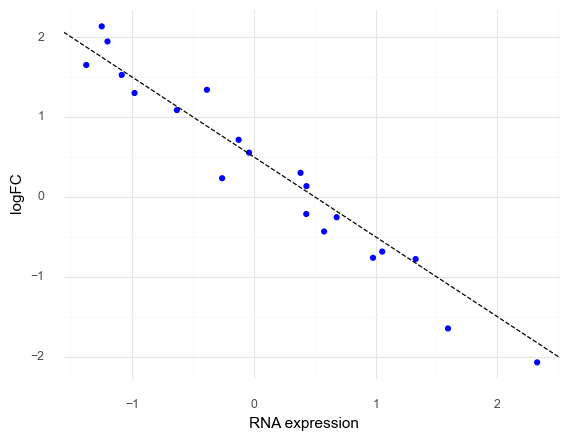

<ggplot: (8786399322613)>

In [4]:
N_CELL_LINES = 20
real_alpha = 0.5
real_beta = -1
real_sigma = 0.3

# Synthetic data
np.random.seed(RANDOM_SEED)
rna = np.random.randn(N_CELL_LINES)
logfc = real_alpha + real_beta * rna + np.random.normal(0, real_sigma, N_CELL_LINES)
data = pd.DataFrame({"rna": rna, "logfc": logfc})

(
    gg.ggplot(data, gg.aes("rna", "logfc"))
    + gg.geom_point(color="blue")
    + gg.geom_abline(slope=real_beta, intercept=real_alpha, linetype="--")
    + gg.labs(x="RNA expression", y="logFC")
)

In [5]:
with pm.Model() as model1:
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 1)
    sigma = pm.HalfNormal("sigma", 5)

    mu = pm.Deterministic("mu", alpha + beta * data.rna)

    logfc = pm.Normal("logfc", mu=mu, sigma=sigma, observed=data.logfc)

    model1_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model1_trace = pm.sample(1000)
    model1_post_check = pm.sample_posterior_predictive(
        model1_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 2000/2000 [00:02<00:00, 821.66it/s]


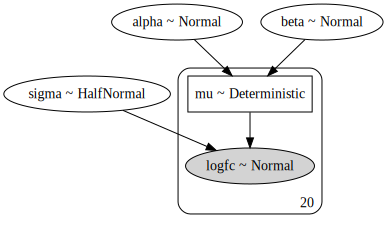

In [57]:
pm.model_to_graphviz(model1)

In [6]:
az_model1 = az.from_pymc3(
    model1_trace, posterior_predictive=model1_post_check, prior=model1_prior_check
)

In [7]:
var_names = ["alpha", "beta", "sigma"]
az.summary(az_model1, var_names=var_names)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.439,0.067,0.304,0.552,0.002,0.001,1935.0,1923.0,1937.0,1369.0,1.0
beta,-1.105,0.062,-1.213,-0.980,0.001,0.001,1760.0,1760.0,1762.0,1376.0,1.0
sigma,0.277,0.052,0.190,0.376,0.001,0.001,1774.0,1709.0,1837.0,1317.0,1.0


/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/

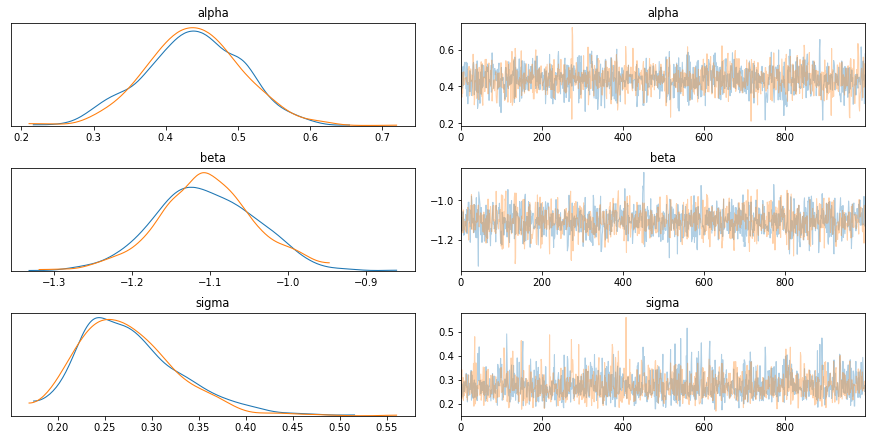

In [8]:
az.plot_trace(az_model1, var_names=var_names)
plt.show()

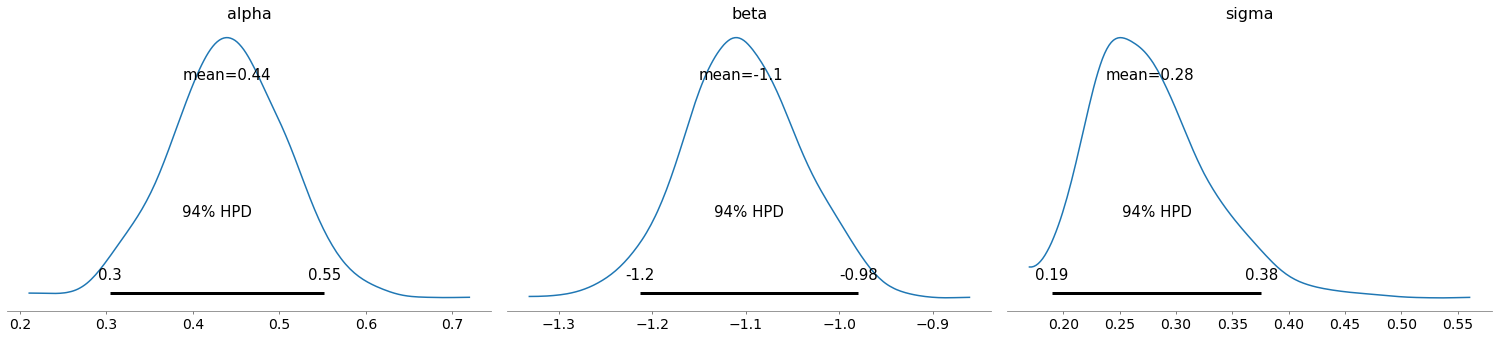

In [9]:
az.plot_posterior(az_model1, var_names=var_names)
plt.show()

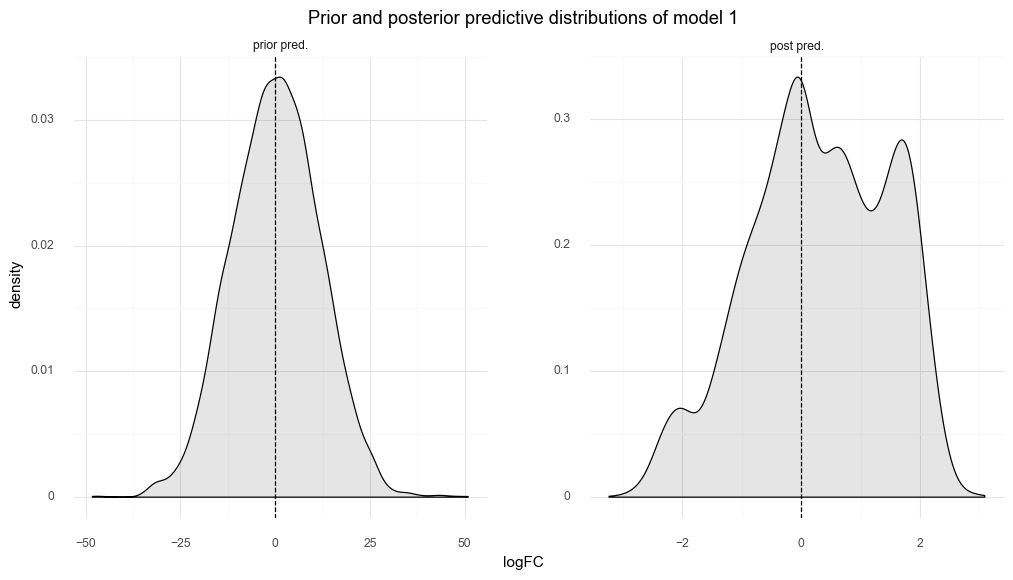

<ggplot: (8786398375625)>

In [10]:
prior_pred = (
    az_model1.prior_predictive.to_dataframe()
    .sample(frac=0.5)
    .assign(pred="prior pred.")
)
post_pred = (
    az_model1.posterior_predictive.to_dataframe()
    .sample(frac=0.2)
    .assign(pred="post pred.")
)
model1_preds = pd.concat([prior_pred, post_pred])
model1_preds["pred"] = pd.Categorical(
    model1_preds.pred, categories=["prior pred.", "post pred."]
)
(
    gg.ggplot(model1_preds, gg.aes("logfc"))
    + gg.facet_wrap("pred", nrow=1, scales="free")
    + gg.geom_density(fill="black", alpha=0.1)
    + gg.geom_vline(xintercept=0, linetype="--")
    + gg.scale_y_continuous(limits=(0, np.nan))
    + gg.labs(
        x="logFC",
        y="density",
        title="Prior and posterior predictive distributions of model 1",
    )
    + gg.theme(figure_size=[12, 6], subplots_adjust={"wspace": 0.25})
)

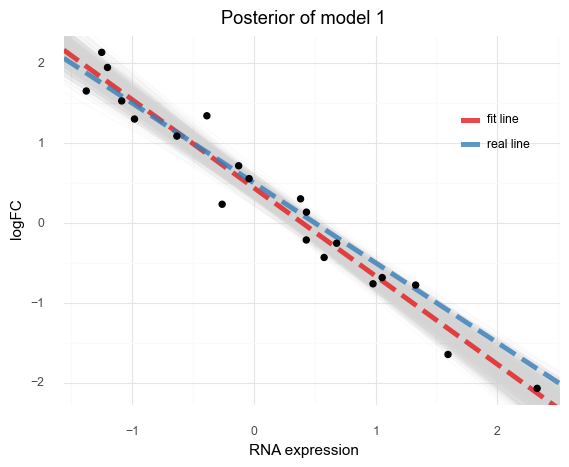

<ggplot: (8786400363829)>

In [11]:
post = az_model1.posterior.to_dataframe()

post_summary = pd.DataFrame(
    {
        "name": ["real line", "fit line"],
        "slope": [real_beta, post.mean()["beta"]],
        "intercept": [real_alpha, post.mean()["alpha"]],
    }
)

(
    gg.ggplot(post.sample(frac=0.1))
    + gg.geom_abline(
        gg.aes(slope="beta", intercept="alpha"), alpha=0.1, color="lightgrey"
    )
    + gg.geom_abline(
        gg.aes(slope="slope", intercept="intercept", color="name"),
        data=post_summary,
        size=2,
        alpha=0.8,
        linetype="--",
    )
    + gg.geom_point(gg.aes(x="rna", y="logfc"), data=data, color="black", size=2)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(legend_position=(0.8, 0.7))
    + gg.labs(x="RNA expression", y="logFC", title="Posterior of model 1", color="")
)

---

## Model 2. Multiple genes hierarchical model with one covariate

Model the logFC of multiple genes in multiple cell lines using a single predictor: RNA expression.
A hierarchcial model will be used to pool information across genes.

$$
logFC \sim Normal(\mu, \sigma) \\
\mu_g = \alpha_g + \beta_g R \\
\alpha_g \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\mu_\alpha \sim \mathcal{N}(0, 10) \qquad \sigma_\alpha \sim \text{HalfNormal}(5) \\
\beta_g \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\mu_\beta \sim \mathcal{N}(0, 10) \qquad \sigma_\beta \sim \text{HalfNormal}(5) \\
\sigma \sim \text{HalfNormal}(5)
$$

Simulated values:

- number of cell lines: 30
- number of genes: 5
- $\mu_\alpha$ = -1, $\sigma_\alpha$ = 1
- $\mu_\beta$ = -1, $\sigma_\beta$ = 2
- $\sigma$ = 0.3

In [44]:
import string

np.random.seed(RANDOM_SEED)

num_cell_lines = 30
num_genes = 5

real_mu_alpha, real_sigma_alpha = -1, 1
real_mu_beta, real_sigma_beta = -1, 2
real_sigma = 0.5

real_alpha = np.random.normal(loc=real_mu_alpha, scale=real_sigma_alpha, size=num_genes)
real_beta = np.random.normal(loc=real_mu_beta, scale=real_sigma_beta, size=num_genes)

genes = ["gene" + a for a in string.ascii_uppercase[:num_genes]]
rna = np.random.randn(num_genes, num_cell_lines)

logfc = (
    real_alpha
    + real_beta * rna.T
    + np.random.normal(loc=0, scale=real_sigma, size=(rna.T.shape))
)
logfc = logfc.T

In [45]:
rna_flat = rna.flatten()
logfc_flat = logfc.flatten()
gene_idx = np.repeat(range(num_genes), num_cell_lines)

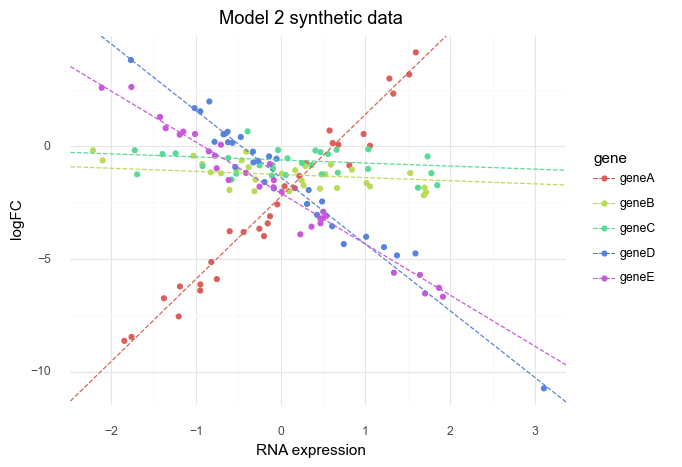

<ggplot: (8786236796025)>

In [46]:
tidy_data = pd.DataFrame(
    {"gene": [genes[i] for i in gene_idx], "rna": rna_flat, "logfc": logfc_flat}
)

tidy_real_data = pd.DataFrame({"alpha": real_alpha, "beta": real_beta, "gene": genes})


(
    gg.ggplot(tidy_data)
    + gg.geom_point(gg.aes(x="rna", y="logfc", color="gene"))
    + gg.geom_abline(
        gg.aes(slope="beta", intercept="alpha", color="gene"),
        data=tidy_real_data,
        linetype="--",
    )
    + gg.labs(
        x="RNA expression", y="logFC", color="gene", title="Model 2 synthetic data"
    )
)

In [47]:
with pm.Model() as model2:
    # Hyper-priors
    mu_alpha = pm.Normal("mu_alpha", 0, 5)
    sigma_alpha = pm.HalfNormal("sigma_alpha", 5)
    mu_beta = pm.Normal("mu_beta", 0, 2)
    sigma_beta = pm.HalfNormal("sigma_beta", 2)

    # Priors
    alpha = pm.Normal("alpha", mu_alpha, sigma_alpha, shape=num_genes)
    beta = pm.Normal("beta", mu_beta, sigma_beta, shape=num_genes)
    mu = pm.Deterministic("mu", alpha[gene_idx] + beta[gene_idx] * rna_flat)
    sigma = pm.HalfNormal("sigma", 5)

    # Likelihood
    logfc = pm.Normal("logfc", mu=mu, sigma=sigma, observed=logfc_flat)

    # Sampling
    model2_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model2_trace = pm.sample(2000, tune=2000)
    model2_post_check = pm.sample_posterior_predictive(
        model2_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
Sampling 2 chains, 2 divergences: 100%|██████████| 8000/8000 [00:11<00:00, 699.64draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 4000/4000 [00:05<00:00, 713.01it/s]


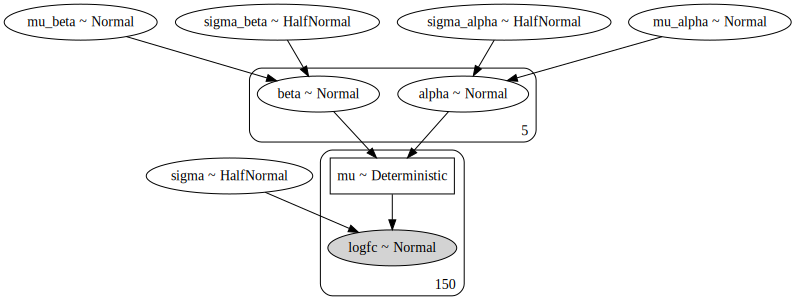

In [58]:
pm.model_to_graphviz(model2)

In [48]:
az_model2 = az.from_pymc3(
    trace=model2_trace, prior=model2_prior_check, posterior_predictive=model2_post_check
)
az.summary(az_model2, var_names=["alpha", "beta", "sigma"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-2.414,0.097,-2.592,-2.228,0.001,0.001,7751.0,7751.0,7715.0,3293.0,1.0
alpha[1],-1.271,0.097,-1.446,-1.082,0.001,0.001,8893.0,8875.0,9014.0,2617.0,1.0
alpha[2],-0.764,0.099,-0.939,-0.568,0.001,0.001,9058.0,8647.0,9087.0,2851.0,1.0
alpha[3],-1.377,0.099,-1.563,-1.191,0.001,0.001,8102.0,8096.0,8119.0,3169.0,1.0
alpha[4],-2.149,0.103,-2.345,-1.960,0.001,0.001,7082.0,7049.0,7077.0,2720.0,1.0
beta[0],3.587,0.107,3.390,3.787,0.001,0.001,8371.0,8331.0,8413.0,2970.0,1.0
beta[1],-0.355,0.101,-0.536,-0.157,0.001,0.001,7656.0,6965.0,7639.0,2580.0,1.0
beta[2],-0.145,0.103,-0.336,0.051,0.001,0.001,8554.0,4536.0,8541.0,3048.0,1.0
beta[3],-2.839,0.102,-3.020,-2.643,0.001,0.001,6684.0,6622.0,6688.0,2715.0,1.0
beta[4],-2.359,0.094,-2.536,-2.183,0.001,0.001,7047.0,6979.0,6996.0,2634.0,1.0


In [49]:
# Real values
pd.DataFrame({"real alpha": real_alpha, "real beta": real_beta})

,real alpha,real beta
0,-2.249278,3.654438
1,-1.260331,-0.138414
2,-0.616207,-0.135368
3,-1.385461,-2.960023
4,-2.085137,-2.263930


/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/

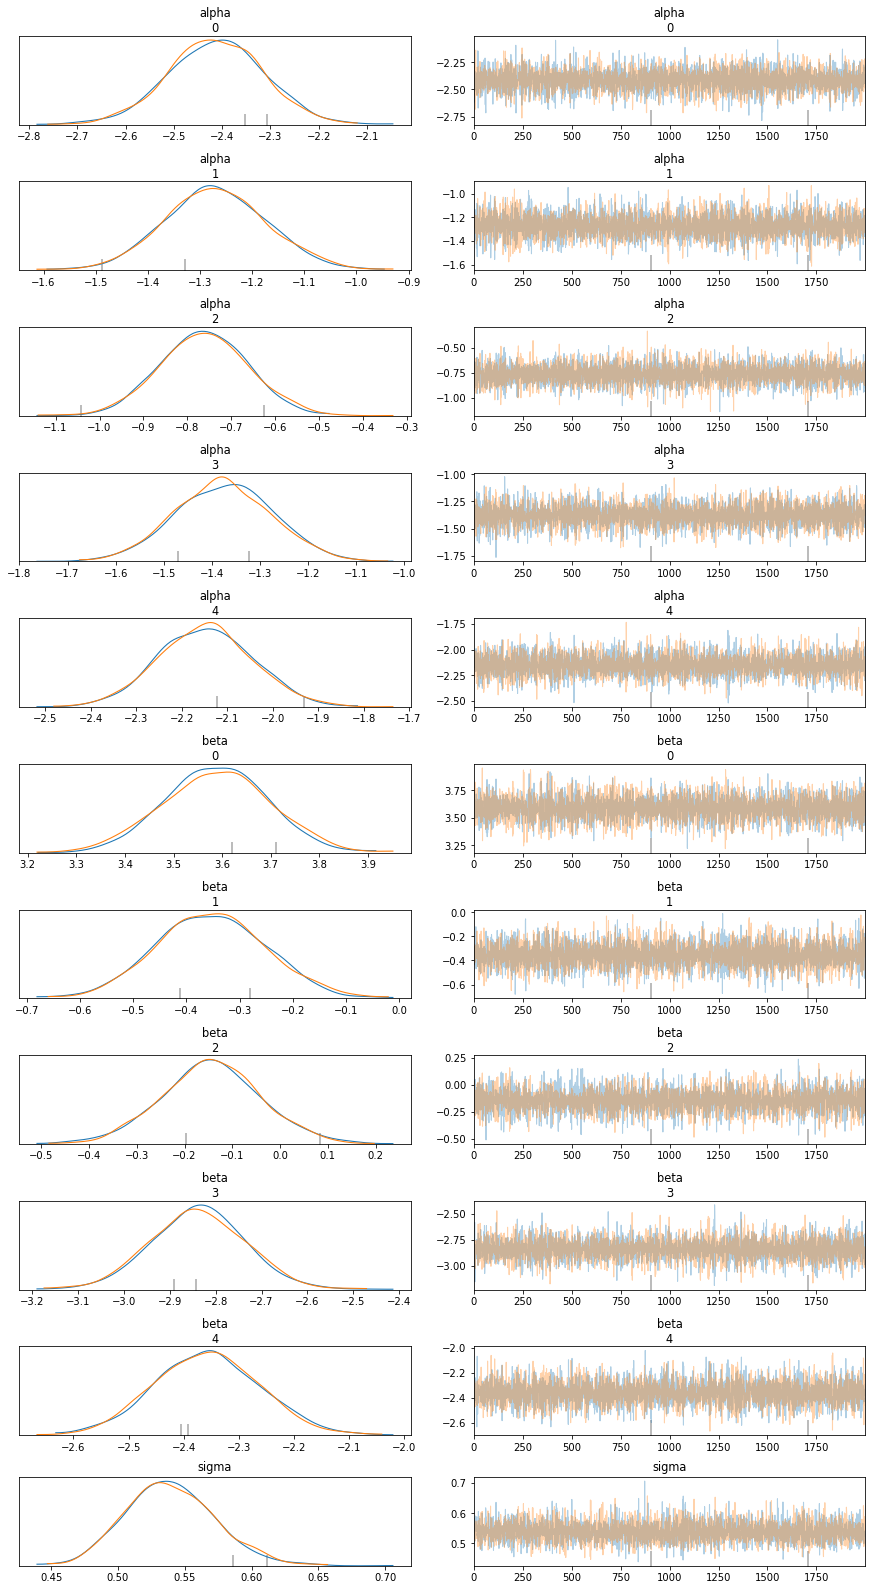

In [50]:
az.plot_trace(az_model2, var_names=var_names)
plt.show()

array([<AxesSubplot:title={'center':'94.0% Credible Interval'}>],
      dtype=object)

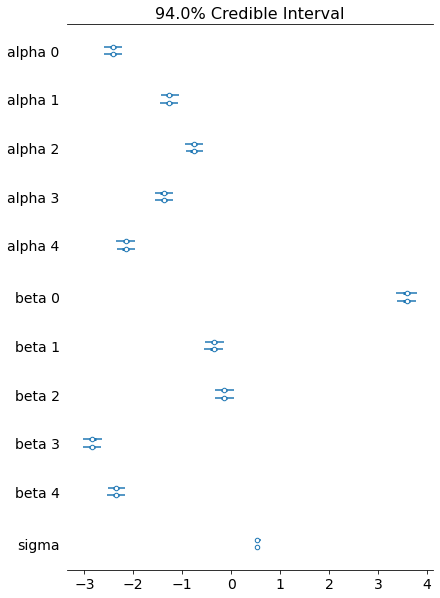

In [51]:
az.plot_forest(az_model2, var_names=var_names)

In [52]:
post = (
    az_model2.posterior.to_dataframe()
    .query("alpha_dim_0 == beta_dim_0")
    .reset_index()
    .groupby(["alpha_dim_0", "beta_dim_0"])
    .apply(lambda x: x.sample(frac=0.1))
    .reset_index(drop=True)
)

In [53]:
post.head()

,alpha_dim_0,beta_dim_0,chain,draw,mu_dim_0,mu_alpha,mu_beta,alpha,beta,sigma_alpha,sigma_beta,mu,sigma
0,0,0,1,1297,58,-2.005934,0.896238,-2.533306,3.537462,1.057965,2.704487,-1.491174,0.513907
1,0,0,0,1427,105,-1.612549,1.361572,-2.416255,3.616562,0.481319,2.038553,-1.192133,0.546126
2,0,0,0,1811,43,-1.090456,-0.989185,-2.351589,3.509903,0.789774,1.742488,-0.946303,0.543524
3,0,0,1,22,50,-1.913872,-0.134479,-2.430872,3.541012,0.541700,2.727996,-1.483219,0.489283
4,0,0,0,1620,46,-0.050011,-1.155751,-2.401856,3.715742,2.398424,3.717638,-1.243279,0.527196


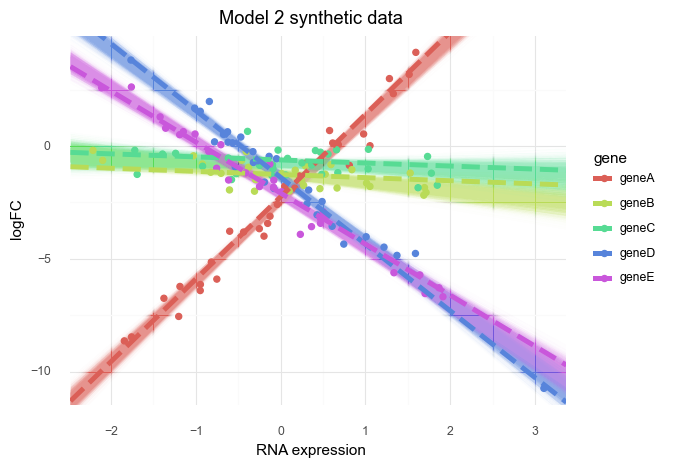

<ggplot: (8786400825553)>

In [54]:
post['gene'] = [genes[i] for i in post.alpha_dim_0]

(
    gg.ggplot(post) +
    gg.geom_abline(gg.aes(slope="beta", intercept="alpha", color = "gene"), alpha=0.01)
     + gg.geom_point(gg.aes(x="rna", y="logfc", color="gene"), data = tidy_data, size = 2)
    + gg.geom_abline(
        gg.aes(slope="beta", intercept="alpha", color="gene"),
        data=tidy_real_data,
        linetype="--",
        size=2
    )
    + gg.labs(
        x="RNA expression", y="logFC", color="gene", title="Model 2 synthetic data"
    )
)

---

## Model 3. Multiple genes and multiple cell lines hierarchical model with one covariate

Model the logFC of multiple genes in multiple cell lines using a single predictor: RNA expression.
A hierarchcial model will be used to pool information across genes and cell lines.

**Note:** Need to include repeated measure of logFC per cell line (but only 1 measure of RNA expression...).

$$
logFC \sim Normal(\mu, \sigma) \\
\mu_{g, c} = \alpha_{g, c} + \beta_{g, c} R \\
\alpha_{g, c} \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\mu_\alpha \sim \mathcal{N}(0, 10) \qquad \sigma_\alpha \sim \text{HalfNormal}(5) \\
\beta{g, c} \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\mu_\beta \sim \mathcal{N}(0, 10) \qquad \sigma_\beta \sim \text{HalfNormal}(5) \\
\sigma \sim \text{HalfNormal}(5)
$$

Simulated values:

- number of cell lines: 30
- number of genes: 5
- $\mu_\alpha$ = -1, $\sigma_\alpha$ = 1
- $\mu_\beta$ = -1, $\sigma_\beta$ = 2
- $\sigma$ = 0.3